In [1]:
from __future__ import annotations

from ast import literal_eval
import sys; sys.path.append("../utils")
import _confusion_matrix
import _ensemble

from IPython.display import display as ipy_display
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import spacy
import enchant

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [3]:
TEXT_EMBS = "../../data/reddit_ell_eng_raw_pos_none_embs.csv"

In [4]:
en = spacy.load('en_core_web_lg')
spacy_fw = en.Defaults.stop_words

print(f"{len(spacy_fw)} function words in spaCy:")
print(", ".join(list(spacy_fw)), end="\n\n")

# tokenize function words to match text tokens
spacy_fw = set([token.text for token in en.tokenizer(" ".join(spacy_fw))])
print(f"{len(spacy_fw)} function words after tokenization:")
print(", ".join(list(spacy_fw)))

326 function words in spaCy:
twenty, during, bottom, give, doing, our, due, he, only, hundred, will, nor, nowhere, has, myself, all, other, becoming, others, into, about, otherwise, were, own, ca, up, ’re, whereupon, an, six, she, there, further, 'll, top, make, former, below, eleven, seems, its, so, ’m, after, elsewhere, four, his, whom, did, does, nobody, between, have, n't, by, no, several, ‘ll, ’d, ’ll, either, formerly, within, themselves, unless, ‘m, had, still, see, yourselves, i, above, fifteen, various, you, almost, wherein, take, towards, besides, none, but, something, sixty, that, say, with, ‘s, every, became, everything, alone, beside, anyhow, fifty, because, amount, too, against, along, thence, can, whereby, in, whole, him, many, very, what, become, 'd, or, around, these, himself, 'm, sometimes, where, becomes, moreover, ‘ve, anywhere, three, and, front, beforehand, yet, each, thereupon, less, herein, them, wherever, nothing, most, me, my, been, 've, name, a, then, through

In [5]:
class MisspellingVectorizer(TfidfVectorizer):
    """A custom vectorizer that only considers misspelled words."""

    def should_be_checked(self, word: str) -> bool:
        """Check if a word needs to be checked for misspelling."""
        return (
            word.isalpha()
            and len(word) > 2
            and not word[0].isupper() # ignore proper nouns (and acronyms)
        )

    def is_misspelled_eng(self, word: str) -> bool:
        """Check if a word is misspelled in either UK or US English."""
        en_UK = enchant.Dict('en_UK')
        en_US = enchant.Dict('en_US')
        return (
            self.should_be_checked(word)
            and not en_UK.check(word)
            and not en_UK.check(word.capitalize())
            and not en_US.check(word)
            and not en_US.check(word.capitalize())
        )

    def get_misspellings(self, X):
        """Get misspelled words from a list of texts."""
        spellcheck = enchant.Dict('en_UK')
        X_miss = [[word for word in x.split() if self.is_misspelled_eng(word)]
                  for x in X]
        print(X_miss, end="\n\n")
        X_miss = [" ".join(text) for text in X_miss]
        return X_miss

    def transform(self, X, y=None):
        X = self.get_misspellings(X)
        return super(MisspellingVectorizer, self).transform(X)

    def fit(self, X, y=None):
        X = self.get_misspellings(X)
        return super(MisspellingVectorizer, self).fit(X, y)


class FunctionWordVectorizer(TfidfVectorizer):
    """A custom vectorizer that only considers function words."""

    def get_function_words(self, X):
        X_fw = [[word for word in x.split() if word in spacy_fw]
                for x in X]
        X_fw = [" ".join(text) for text in X_fw]
        return X_fw

    def transform(self, X, y=None):
        X = self.get_function_words(X)
        return super(FunctionWordVectorizer, self).transform(X)

    def fit(self, X, y=None):
        X = self.get_function_words(X)
        return super(FunctionWordVectorizer, self).fit(X, y)


class ColumnSelector(BaseEstimator, TransformerMixin):
    """A custom transformer that selects columns from a dataframe."""

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.columns]

In [6]:
all_cv_results = pd.DataFrame()
all_best_params = pd.DataFrame()
all_grid_preds = pd.DataFrame()

In [7]:
df = pd.read_csv(TEXT_EMBS, encoding='utf-8')

df, labels = encode_labels(df, 'label')

df['gpt2'] = df['gpt2'].apply(literal_eval).apply(np.array)
df['gpt2'] = df['gpt2'].apply(lambda x: x.reshape(-1))  # flatten the array

X = pd.concat([df['gpt2'].apply(pd.Series).rename(columns=lambda x: f"emb_{x}"),
               df['text'], df['pos_tags'], df['pos_fw']], axis=1)
y = df['label']

emb_cols = [col for col in X.columns if col.startswith('emb_')]

gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['user_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, end="\n\n")

mspl_vect = MisspellingVectorizer(ngram_range=(1, 10))
fw_vect = FunctionWordVectorizer(ngram_range=(1, 10))
word_vect = TfidfVectorizer(ngram_range=(1, 5))
char_vect = TfidfVectorizer(ngram_range=(1, 5), analyzer='char')
pos_vect = TfidfVectorizer(ngram_range=(1, 5))

cxf = ColumnTransformer([
        ('word', word_vect, 'text'),
        ('fw', fw_vect, 'text'),
        ('mspl', mspl_vect, 'text'),
        ('char', char_vect, 'text'),
        ('pos', pos_vect, 'pos_tags'),
    ], remainder='drop') # drop embeddings

# linguistic pipelines
lsvm_pipe = Pipeline([
    ('cxf', cxf), 
    ('clf', SGDClassifier(loss='hinge')), # LinearSVM
])

logreg_pipe = Pipeline([
    ('cxf', cxf),
    ('clf', SGDClassifier(loss='log_loss')), # LogReg
])

# embeddings pipelines
sgdc_pipe = Pipeline([
    ('cxf', ColumnTransformer([
        ('emb', 'passthrough', emb_cols),
    ], remainder='drop')), # drop linguistic features
    ('clf', SGDClassifier()), # let grid search decide the loss
])

models_df = pd.DataFrame({
    'model': [
        'LSVM',
        'LogReg',
        'SGDC',
    ],
    'pipe': [
        lsvm_pipe,
        logreg_pipe,
        sgdc_pipe,
    ],
    'params': [
        {
            'cxf__mspl__binary': [True, False],
            'cxf__fw__binary': [True, False],
            'cxf__pos__binary': [True, False],
        },
        {
            'cxf__mspl__binary': [True, False],
            'cxf__fw__binary': [True, False],
            'cxf__pos__binary': [True, False],
        },
        {
            'clf__loss': ['hinge', 'log_loss'] # => LSVM, LogReg
        },
    ],
    'feature_set': [
        'linguistic',
        'linguistic',
        'embeddings',
    ],
})

(8286, 1539) (1633, 1539) (8286,) (1633,)



======================================LSVM======================================
-------------------------------With maxlen='none'-------------------------------
---------------------------Using linguistic features----------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best hyperparameters:
{'cxf__fw__binary': False, 'cxf__mspl__binary': True, 'cxf__pos__binary': False}



,cxf__fw__binary,cxf__mspl__binary,cxf__pos__binary,model,feature_set
0,False,True,False,LSVM,linguistic


[['tbh', 'unfuck'], ['befor'], [], [], [], [], ['reddit'], [], [], [], ['miza'], ['eurozone'], [], ['antieuropean'], [], [], [], [], ['suppoort'], [], ['ayy', 'electic'], [], [], [], [], [], ['intimidanting', 'extorsions'], ['thats', 'guaranting'], [], [], [], ['pHD'], [], [], [], [], ['prefered'], [], [], [], [], [], ['btw'], ['syriza'], ['correllate'], [], [], [], [], [], [], ['gon'], [], [], [], [], [], [], ['evergoing'], ['samothraki', 'limnos', 'rodos', 'mytelene', 'leros'], [], [], [], [], [], [], [], ['tresspassing'], ['marocco'], ['barrell'], [], ['symbolisms'], [], [], [], ['critisizing'], [], [], ['highschool', 'choises', 'lol'], [], [], ['greatfullness', 'wasnt', 'eachother'], ['imposible', 'invesment'], ['vero'], ['wil'], [], [], [], ['underqualified'], [], [], [], [], [], [], [], [], [], ['govts'], [], [], [], [], [], [], [], [], [], [], ['subreddit'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['mispelled'], [], ['exageration'], []

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cxf__fw__binary,param_cxf__mspl__binary,param_cxf__pos__binary,params,split0_test_score,split1_test_score,...,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,model
0,103.481214,3.266655,9322.410178,232.098950,True,True,True,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.701117,0.770924,...,0.820368,0.789815,0.790549,0.822109,0.853863,0.811335,0.783964,0.045024,7,LSVM
1,96.619188,9.174845,9270.425177,200.188997,True,True,False,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.707565,0.779400,...,0.828896,0.784807,0.797541,0.827083,0.849007,0.804032,0.785846,0.045629,5,LSVM
2,84.888686,0.936011,9183.300479,240.696437,True,False,True,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.704168,0.774330,...,0.821330,0.782171,0.787196,0.822181,0.857487,0.813273,0.783033,0.046299,8,LSVM
3,83.288623,1.158657,9091.424279,248.790915,True,False,False,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.710251,0.776619,...,0.822656,0.779866,0.794627,0.825888,0.850228,0.819606,0.785952,0.044696,4,LSVM
4,83.361701,0.786386,9046.199522,222.887788,False,True,True,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.712842,0.766923,...,0.828247,0.796121,0.791048,0.833255,0.852636,0.812089,0.787425,0.044661,2,LSVM
5,84.261832,0.694735,8927.566640,231.590162,False,True,False,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.707269,0.778570,...,0.824107,0.787532,0.793345,0.833193,0.861038,0.812756,0.788226,0.046667,1,LSVM
6,83.851235,0.766582,9057.929608,275.519308,False,False,True,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.706445,0.771730,...,0.826469,0.797339,0.793319,0.830855,0.849028,0.811415,0.784956,0.046954,6,LSVM
7,84.126561,0.807230,9026.824720,167.016681,False,False,False,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.700387,0.778737,...,0.831614,0.788901,0.801319,0.824601,0.853803,0.803688,0.787067,0.045648,3,LSVM


,LSVM_pred,LSVM_true
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0
...,...,...
1628,1,1
1629,1,1
1630,1,1
1631,1,1


LSVM done

=====================================LogReg=====================================
-------------------------------With maxlen='none'-------------------------------
---------------------------Using linguistic features----------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best hyperparameters:
{'cxf__fw__binary': False, 'cxf__mspl__binary': False, 'cxf__pos__binary': True}



,cxf__fw__binary,cxf__mspl__binary,cxf__pos__binary,model,feature_set
0,False,True,False,LSVM,linguistic
1,False,False,True,LogReg,linguistic


[['tbh', 'unfuck'], ['befor'], [], [], [], [], ['reddit'], [], [], [], ['miza'], ['eurozone'], [], ['antieuropean'], [], [], [], [], ['suppoort'], [], ['ayy', 'electic'], [], [], [], [], [], ['intimidanting', 'extorsions'], ['thats', 'guaranting'], [], [], [], ['pHD'], [], [], [], [], ['prefered'], [], [], [], [], [], ['btw'], ['syriza'], ['correllate'], [], [], [], [], [], [], ['gon'], [], [], [], [], [], [], ['evergoing'], ['samothraki', 'limnos', 'rodos', 'mytelene', 'leros'], [], [], [], [], [], [], [], ['tresspassing'], ['marocco'], ['barrell'], [], ['symbolisms'], [], [], [], ['critisizing'], [], [], ['highschool', 'choises', 'lol'], [], [], ['greatfullness', 'wasnt', 'eachother'], ['imposible', 'invesment'], ['vero'], ['wil'], [], [], [], ['underqualified'], [], [], [], [], [], [], [], [], [], ['govts'], [], [], [], [], [], [], [], [], [], [], ['subreddit'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['mispelled'], [], ['exageration'], []

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cxf__fw__binary,param_cxf__mspl__binary,param_cxf__pos__binary,params,split0_test_score,split1_test_score,...,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,model
0,103.481214,3.266655,9322.410178,232.098950,True,True,True,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.701117,0.770924,...,0.820368,0.789815,0.790549,0.822109,0.853863,0.811335,0.783964,0.045024,7,LSVM
1,96.619188,9.174845,9270.425177,200.188997,True,True,False,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.707565,0.779400,...,0.828896,0.784807,0.797541,0.827083,0.849007,0.804032,0.785846,0.045629,5,LSVM
2,84.888686,0.936011,9183.300479,240.696437,True,False,True,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.704168,0.774330,...,0.821330,0.782171,0.787196,0.822181,0.857487,0.813273,0.783033,0.046299,8,LSVM
3,83.288623,1.158657,9091.424279,248.790915,True,False,False,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.710251,0.776619,...,0.822656,0.779866,0.794627,0.825888,0.850228,0.819606,0.785952,0.044696,4,LSVM
4,83.361701,0.786386,9046.199522,222.887788,False,True,True,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.712842,0.766923,...,0.828247,0.796121,0.791048,0.833255,0.852636,0.812089,0.787425,0.044661,2,LSVM
5,84.261832,0.694735,8927.566640,231.590162,False,True,False,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.707269,0.778570,...,0.824107,0.787532,0.793345,0.833193,0.861038,0.812756,0.788226,0.046667,1,LSVM
6,83.851235,0.766582,9057.929608,275.519308,False,False,True,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.706445,0.771730,...,0.826469,0.797339,0.793319,0.830855,0.849028,0.811415,0.784956,0.046954,6,LSVM
7,84.126561,0.807230,9026.824720,167.016681,False,False,False,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.700387,0.778737,...,0.831614,0.788901,0.801319,0.824601,0.853803,0.803688,0.787067,0.045648,3,LSVM
0,116.044243,4.083920,10393.134838,265.084938,True,True,True,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.704103,0.779507,...,0.823686,0.788547,0.782680,0.823338,0.853859,0.799971,0.782217,0.046363,6,LogReg
1,105.643690,12.289231,10339.363848,225.400563,True,True,False,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.714490,0.786615,...,0.823761,0.778684,0.795879,0.834535,0.852636,0.791382,0.785208,0.044347,2,LogReg


,LSVM_pred,LSVM_true,LogReg_pred,LogReg_true
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,1,0,1,0
4,0,0,0,0
...,...,...,...,...
1628,1,1,1,1
1629,1,1,1,1
1630,1,1,1,1
1631,1,1,1,1


LogReg done

======================================SGDC======================================
-------------------------------With maxlen='none'-------------------------------
---------------------------Using embeddings features----------------------------
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Best hyperparameters:
{'clf__loss': 'log_loss'}



,cxf__fw__binary,cxf__mspl__binary,cxf__pos__binary,model,feature_set,clf__loss
0,False,True,False,LSVM,linguistic,NaN
1,False,False,True,LogReg,linguistic,NaN
2,NaN,NaN,NaN,SGDC,embeddings,log_loss


              precision    recall  f1-score   support

           0       0.89      0.67      0.76       938
           1       0.66      0.88      0.76       695

    accuracy                           0.76      1633
   macro avg       0.77      0.77      0.76      1633
weighted avg       0.79      0.76      0.76      1633

Saved confusion matrix: ../results/figures/gridsearchcv_0.758__grid__sgdc_20230105_1154.svg


C:\Users\dimboump\AppData\Local\Temp\ipykernel_140060\586306161.py:30: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  all_cv_results = pd.concat([all_cv_results, cv_results])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cxf__fw__binary,param_cxf__mspl__binary,param_cxf__pos__binary,params,split0_test_score,split1_test_score,...,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,model,param_clf__loss
0,103.481214,3.266655,9322.410178,232.098950,True,True,True,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.701117,0.770924,...,0.789815,0.790549,0.822109,0.853863,0.811335,0.783964,0.045024,7,LSVM,NaN
1,96.619188,9.174845,9270.425177,200.188997,True,True,False,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.707565,0.779400,...,0.784807,0.797541,0.827083,0.849007,0.804032,0.785846,0.045629,5,LSVM,NaN
2,84.888686,0.936011,9183.300479,240.696437,True,False,True,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.704168,0.774330,...,0.782171,0.787196,0.822181,0.857487,0.813273,0.783033,0.046299,8,LSVM,NaN
3,83.288623,1.158657,9091.424279,248.790915,True,False,False,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.710251,0.776619,...,0.779866,0.794627,0.825888,0.850228,0.819606,0.785952,0.044696,4,LSVM,NaN
4,83.361701,0.786386,9046.199522,222.887788,False,True,True,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.712842,0.766923,...,0.796121,0.791048,0.833255,0.852636,0.812089,0.787425,0.044661,2,LSVM,NaN
5,84.261832,0.694735,8927.566640,231.590162,False,True,False,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.707269,0.778570,...,0.787532,0.793345,0.833193,0.861038,0.812756,0.788226,0.046667,1,LSVM,NaN
6,83.851235,0.766582,9057.929608,275.519308,False,False,True,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.706445,0.771730,...,0.797339,0.793319,0.830855,0.849028,0.811415,0.784956,0.046954,6,LSVM,NaN
7,84.126561,0.807230,9026.824720,167.016681,False,False,False,"{'cxf__fw__binary': False, 'cxf__mspl__binary'...",0.700387,0.778737,...,0.788901,0.801319,0.824601,0.853803,0.803688,0.787067,0.045648,3,LSVM,NaN
0,116.044243,4.083920,10393.134838,265.084938,True,True,True,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.704103,0.779507,...,0.788547,0.782680,0.823338,0.853859,0.799971,0.782217,0.046363,6,LogReg,NaN
1,105.643690,12.289231,10339.363848,225.400563,True,True,False,"{'cxf__fw__binary': True, 'cxf__mspl__binary':...",0.714490,0.786615,...,0.778684,0.795879,0.834535,0.852636,0.791382,0.785208,0.044347,2,LogReg,NaN


,LSVM_pred,LSVM_true,LogReg_pred,LogReg_true,SGDC_pred,SGDC_true
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,1,0,1,0,1,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
1628,1,1,1,1,1,1
1629,1,1,1,1,1,1
1630,1,1,1,1,1,1
1631,1,1,1,1,1,1


SGDC done



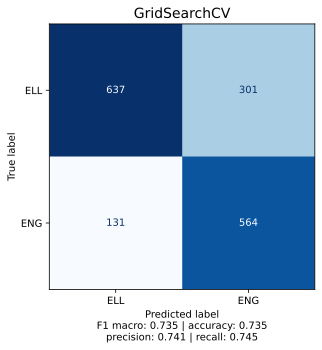

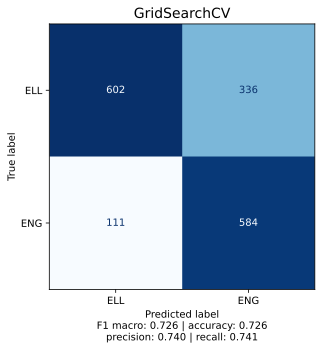

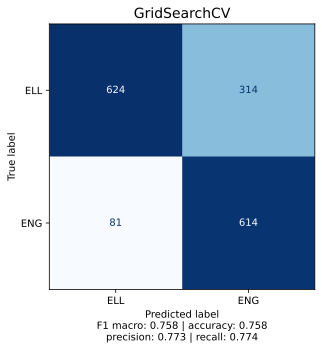

In [8]:
# individual models training with grid search
for i, row in models_df.iterrows():
    model = row['model']
    params = row['params']
    feature_set = row['feature_set']
    pipe = row['pipe']
    print(f"{model}".center(80, '='))
    print(f"With maxlen='none'".center(80, '-'))
    print(f"Using {feature_set} features".center(80, '-'))
    gs = GridSearchCV(pipe, params, cv=10, n_jobs=-1, scoring='f1_macro', verbose=5)
    gs.fit(X_train, y_train)

    gs_best_params = pd.DataFrame(gs.best_params_, index=[i])
    print("Best hyperparameters:", gs.best_params_, sep="\n", end="\n\n")
    gs_best_params['model'] = row['model']
    gs_best_params['feature_set'] = row['feature_set']
    all_best_params = pd.concat([all_best_params, gs_best_params])
    ipy_display(all_best_params)

    comment = f'_{model.lower()}'
    y_pred = gs.predict(X_test)
    gs_report = classification_report(y_test, gs.predict(X_test), output_dict=True)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    _confusion_matrix.plot_cm(cm, pipe=gs, report=gs_report, labels=labels, colorbar=False, export=True, comment=f'_grid_{comment}')
    _ensemble.save_predictions(y_test, y_pred, pipe=gs, report=gs_report, export=True, comment=f'_grid_{comment}')

    cv_results = pd.DataFrame(gs.cv_results_)
    cv_results['model'] = row['model']
    all_cv_results = pd.concat([all_cv_results, cv_results])
    ipy_display(all_cv_results)

    all_grid_preds[f"{model}_pred"] = y_pred
    all_grid_preds[f"{model}_true"] = y_test.values
    ipy_display(all_grid_preds)

    print(f"{model} done", end="\n\n")

In [9]:
all_best_params = all_best_params.set_index(['model', 'feature_set']).sort_index()
all_best_params

,,cxf__fw__binary,cxf__mspl__binary,cxf__pos__binary,clf__loss
model,feature_set,,,,
LSVM,linguistic,False,True,False,NaN
LogReg,linguistic,False,False,True,NaN
SGDC,embeddings,NaN,NaN,NaN,log_loss


[['tbh', 'unfuck'], ['befor'], [], [], [], [], ['reddit'], [], [], [], ['miza'], ['eurozone'], [], ['antieuropean'], [], [], [], [], ['suppoort'], [], ['ayy', 'electic'], [], [], [], [], [], ['intimidanting', 'extorsions'], ['thats', 'guaranting'], [], [], [], ['pHD'], [], [], [], [], ['prefered'], [], [], [], [], [], ['btw'], ['syriza'], ['correllate'], [], [], [], [], [], [], ['gon'], [], [], [], [], [], [], ['evergoing'], ['samothraki', 'limnos', 'rodos', 'mytelene', 'leros'], [], [], [], [], [], [], [], ['tresspassing'], ['marocco'], ['barrell'], [], ['symbolisms'], [], [], [], ['critisizing'], [], [], ['highschool', 'choises', 'lol'], [], [], ['greatfullness', 'wasnt', 'eachother'], ['imposible', 'invesment'], ['vero'], ['wil'], [], [], [], ['underqualified'], [], [], [], [], [], [], [], [], [], ['govts'], [], [], [], [], [], [], [], [], [], [], ['subreddit'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['mispelled'], [], ['exageration'], []

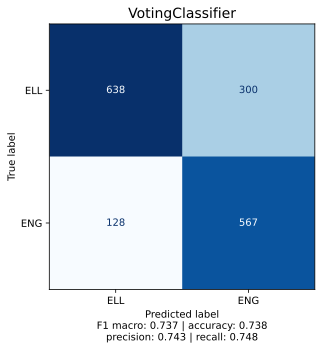

In [10]:
# assign best params to models if the value is not NaN
lsvm_params = all_best_params.loc['LSVM', 'linguistic'].to_dict()
lsvm_params = {k: v for k, v in lsvm_params.items()
                    if k.startswith('clf__') and not pd.isnull(v)}

logreg_params = all_best_params.loc['LogReg', 'linguistic'].to_dict()
logreg_params = {k: v for k, v in logreg_params.items()
                      if k.startswith('clf__') and not pd.isnull(v)}

sgdc_params = all_best_params.loc['SGDC', 'embeddings'].to_dict()
sgdc_params = {k: v for k, v in sgdc_params.items()
                    if k.startswith('clf__') and not pd.isnull(v)}

# train voting classifier with best models
vclf = VotingClassifier([
    ('lsvm', lsvm_pipe.set_params(**lsvm_params)),
    ('logreg', logreg_pipe.set_params(**logreg_params)),
    ('sgdc', sgdc_pipe.set_params(**sgdc_params)),
], voting='hard') # majority voting

vclf.fit(X_train, y_train)
y_pred = vclf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
_confusion_matrix.plot_cm(cm, pipe=vclf, report=report, labels=labels, colorbar=False, export=True, comment=f'_ensemble')

In [17]:
# check if the voting classifier is better than the best individual model
best_model = all_cv_results.sort_values('rank_test_score').iloc[0]
ipy_display(best_model)

# save predictions
all_grid_preds['ensemble_pred'] = y_pred
all_grid_preds['ensemble_true'] = y_test.values
all_grid_preds.to_csv('ensemble__all_predictions.csv', index=False)

mean_fit_time                               1.672029
std_fit_time                                0.386709
mean_score_time                             0.023854
std_score_time                              0.007377
param_cxf__fw__binary                            NaN
param_cxf__mspl__binary                          NaN
param_cxf__pos__binary                           NaN
params                     {'clf__loss': 'log_loss'}
split0_test_score                           0.776879
split1_test_score                           0.817611
split2_test_score                            0.79232
split3_test_score                           0.776403
split4_test_score                           0.835622
split5_test_score                            0.80063
split6_test_score                           0.825549
split7_test_score                           0.870768
split8_test_score                           0.887681
split9_test_score                           0.813922
mean_test_score                             0.

In [18]:
# check whether all _true columns are the same
print(all(all_grid_preds['ensemble_true'] == all_grid_preds['LSVM_true']))
print(all(all_grid_preds['ensemble_true'] == all_grid_preds['LogReg_true']))
print(all(all_grid_preds['ensemble_true'] == all_grid_preds['SGDC_true']))

True
True
True


In [44]:
# Get wrong predictions for error analysis
wrong_preds = all_grid_preds[all_grid_preds['ensemble_pred'] != all_grid_preds['ensemble_true']]
wrong_preds = wrong_preds.drop([col for col in wrong_preds.columns if col.endswith('_true') and col != 'ensemble_true'], axis=1)
wrong_preds = wrong_preds.rename(columns={'ensemble_true': 'true', 'ensemble_pred': 'pred'})
wrong_preds = wrong_preds.rename(columns={col: col.replace('_pred', '') for col in wrong_preds.columns})
wrong_preds.to_csv('ensemble__wrong_predictions.csv', index=False, encoding='utf-8')

wrong_preds_styled = wrong_preds.style.background_gradient(cmap='RdBu', subset=['true', 'pred'])
wrong_preds_styled

,LSVM,LogReg,SGDC,pred,true
3,1,1,1,1,0
6,1,1,1,1,0
16,0,1,0,1,0
34,1,1,0,1,0
44,1,1,0,1,0
65,1,1,1,1,0
68,1,0,1,1,0
80,1,1,1,1,0
91,1,1,1,1,0
95,1,1,1,1,0


In [57]:
embs_rule = wrong_preds.copy()
embs_rule = embs_rule[(embs_rule['LSVM'] == embs_rule['LogReg'])
                      & (embs_rule['SGDC'] == embs_rule['true'])
                      & (embs_rule['LSVM'] != embs_rule['true'])]
ipy_display(embs_rule)

,LSVM,LogReg,SGDC,pred,true
34,1,1,0,1,0
44,1,1,0,1,0
99,1,1,0,1,0
106,1,1,0,1,0
110,1,1,0,1,0
...,...,...,...,...,...
1566,0,0,1,0,1
1570,0,0,1,0,1
1593,0,0,1,0,1
1603,0,0,1,0,1


> The Embeddings-only model predicted correctly 149 samples where the other models predicted the wrong class!

In [58]:
embs_dissapoint = wrong_preds.copy()
embs_dissapoint = embs_dissapoint[(embs_dissapoint['LSVM'] == embs_dissapoint['LogReg'])
                                      & (embs_dissapoint['LSVM'] == embs_dissapoint['true'])
                                      & (embs_dissapoint['SGDC'] != embs_dissapoint['true'])]
ipy_display(embs_dissapoint)

,LSVM,LogReg,SGDC,pred,true
1259,1,1,0,0,1
1261,1,1,0,0,1
1296,1,1,0,0,1
1525,1,1,0,0,1


> The opposite in true for... 4 samples!

In [61]:
crl = all_grid_preds[[col for col in all_grid_preds.columns if col.endswith('_pred')] + ['ensemble_true']].corr()
crl.style.background_gradient(cmap='RdBu')

,LSVM_pred,LogReg_pred,SGDC_pred,ensemble_pred,ensemble_true
LSVM_pred,1.000000,0.887281,0.588139,0.931164,0.486011
LogReg_pred,0.887281,1.000000,0.591238,0.914315,0.480588
SGDC_pred,0.588139,0.591238,1.000000,0.625049,0.547721
ensemble_pred,0.931164,0.914315,0.625049,1.000000,0.491417
ensemble_true,0.486011,0.480588,0.547721,0.491417,1.000000


In [82]:
# get totally wrong predictions, i.e., where ALL models predicted wrong
totally_wrong = (
    wrong_preds[
        (wrong_preds['LSVM'] != wrong_preds['true']) &
        (wrong_preds['LogReg'] != wrong_preds['true']) &
        (wrong_preds['SGDC'] != wrong_preds['true'])]
            # bring over the texts from the original dataset
            .assign(
                text=lambda _df: _df.index.map(lambda i: df.loc[i, 'text']),
                n_words=lambda _df: _df['text'].str.split().str.len(),
                n_punct=lambda _df: _df['text'].str.count(r'[^\w\s\d]'),
            )
            .reindex(columns=['text', 'n_words', 'n_punct', 'true', 'LSVM', 'LogReg', 'SGDC'])
)
totally_wrong.to_csv('ensemble__totally_wrong_predictions.csv', index=False, encoding='utf-8')

totally_wrong_sty = totally_wrong.style.background_gradient(cmap='RdBu', axis=1, subset=['true', 'LSVM', 'LogReg', 'SGDC'])
totally_wrong_sty

,text,n_words,n_punct,true,LSVM,LogReg,SGDC
3,"Money is important to me because I do n't have a state that will look after me - in fact the pension is going to be scrapped well before I 'm retired , and our retirement fund system is being taxed the hell out of so there 's not much incentive to save for retirement given that the investment just gets taken by the government anyway ... And when I mean `` taken '' , this is meant to be a fund that can support a person from 00 years of age until their death .",96,14,0,1,1,1
6,We have so many in AU and I always have to research the company affiliated before donating because often it 's another money sink ... To really help Africa on a large scale we 'd need some more trustworthy companies that actually vow to minimise costs who set up in country rather than try to help from a head office overseas . .,63,7,0,1,1,1
65,"Indicative of this is that even though much of the Greek economy is sanctioned by the public sector , the amount of genuine public employees as a percentage of the workforce in Greece was among the lowest in Europe before the crash , [ is the lowest in Europe right now ] ( http://www.iiea.com/ftp/Images/Blogs/July0000/FinalSizeInfograph.jpg ) , and it 's still been going nothing but down as more and more state assets become public interest companies with the privatization plan .",80,20,0,1,1,1
80,"Why not say something like `` We are confident that our proposed reforms will pay off in the future , maybe not immediately '' or `` It is perfectly understood that we did n't do enough initially but we are prepared to do things right this time '' Or pretty much anything other than fanfare .",56,11,0,1,1,1
91,About the author : > James K. Galbraith is the author of `` Welcome to the Poisoned Chalice : The Destruction of Greece and the Future of Europe . '' He teaches at the LBJ School at the University of Texas at Austin and he assisted Greek Finance Minister Varoufakis in 0000 . in case you missed it : > He assisted Greek Finance Minister Varoufakis in 0000 .,69,13,0,1,1,1
95,"I can ` find any source for this anywhere but I saw in the news that 00 days after the official licences will be handed to those who paid for them , the State Communications Agency will request the rights to the spectrum be handed to the public from the numerous broadcasting firms .",54,3,0,1,1,1
100,"Parents the other day at a school in rural Greece said they did n't want refugee children to study at their school district building in the afternoon , and everyone on the national news and parliament recoiled in horror , only to then actually read their statement which wa n't racist or anything , it was a matter of parents being worried for public health , and asking the government if the kids are properly vaccinated ... Are there racist bigots in Greece ?",84,10,0,1,1,1
103,"This is n't to say that I would n't be troubled and quite frankly horrified , but at this point , with literally everyone I know being so negative and so vocal towards these people , I probably would n't risk standing up for them in public , and as a result of that , I probably would quickly forget about it , do other things and at the end of the day be apathetic .",76,10,0,1,1,1
117,"> Modern Greece is barely 00 years old > Modern Greek culture has no connection to Ancient or Medieval Greek culture > Not realizing that modern Greece was one of the first liberal democracies in Europe > Greeks like Russia because of religious and cultural ties , how dare they do n't like the nations ** WE ** have religious and cultural ties with !?",65,12,0,1,1,1
119,"But there is just so much marble out there from so many periods that moving it all into museums or enclosing it all on sight would be impossible , and the corrosion of structural pieces like columns is actually more dangerous , as they loose their weight baring capacity as they loose mass at the edges .",57,3,0,1,1,1


In [2]:
totally_wrong = pd.read_csv('ensemble__totally_wrong_predictions.csv', encoding='utf-8')

totally_wrong_sty = totally_wrong.style.background_gradient(cmap='RdBu', axis=1, subset=['true', 'LSVM', 'LogReg', 'SGDC'])
totally_wrong_sty

,text,n_words,n_punct,true,LSVM,LogReg,SGDC
0,"Money is important to me because I do n't have a state that will look after me - in fact the pension is going to be scrapped well before I 'm retired , and our retirement fund system is being taxed the hell out of so there 's not much incentive to save for retirement given that the investment just gets taken by the government anyway ... And when I mean `` taken '' , this is meant to be a fund that can support a person from 00 years of age until their death .",96,14,0,1,1,1
1,We have so many in AU and I always have to research the company affiliated before donating because often it 's another money sink ... To really help Africa on a large scale we 'd need some more trustworthy companies that actually vow to minimise costs who set up in country rather than try to help from a head office overseas . .,63,7,0,1,1,1
2,"Indicative of this is that even though much of the Greek economy is sanctioned by the public sector , the amount of genuine public employees as a percentage of the workforce in Greece was among the lowest in Europe before the crash , [ is the lowest in Europe right now ] ( http://www.iiea.com/ftp/Images/Blogs/July0000/FinalSizeInfograph.jpg ) , and it 's still been going nothing but down as more and more state assets become public interest companies with the privatization plan .",80,20,0,1,1,1
3,"Why not say something like `` We are confident that our proposed reforms will pay off in the future , maybe not immediately '' or `` It is perfectly understood that we did n't do enough initially but we are prepared to do things right this time '' Or pretty much anything other than fanfare .",56,11,0,1,1,1
4,About the author : > James K. Galbraith is the author of `` Welcome to the Poisoned Chalice : The Destruction of Greece and the Future of Europe . '' He teaches at the LBJ School at the University of Texas at Austin and he assisted Greek Finance Minister Varoufakis in 0000 . in case you missed it : > He assisted Greek Finance Minister Varoufakis in 0000 .,69,13,0,1,1,1
5,"I can ` find any source for this anywhere but I saw in the news that 00 days after the official licences will be handed to those who paid for them , the State Communications Agency will request the rights to the spectrum be handed to the public from the numerous broadcasting firms .",54,3,0,1,1,1
6,"Parents the other day at a school in rural Greece said they did n't want refugee children to study at their school district building in the afternoon , and everyone on the national news and parliament recoiled in horror , only to then actually read their statement which wa n't racist or anything , it was a matter of parents being worried for public health , and asking the government if the kids are properly vaccinated ... Are there racist bigots in Greece ?",84,10,0,1,1,1
7,"This is n't to say that I would n't be troubled and quite frankly horrified , but at this point , with literally everyone I know being so negative and so vocal towards these people , I probably would n't risk standing up for them in public , and as a result of that , I probably would quickly forget about it , do other things and at the end of the day be apathetic .",76,10,0,1,1,1
8,"> Modern Greece is barely 00 years old > Modern Greek culture has no connection to Ancient or Medieval Greek culture > Not realizing that modern Greece was one of the first liberal democracies in Europe > Greeks like Russia because of religious and cultural ties , how dare they do n't like the nations ** WE ** have religious and cultural ties with !?",65,12,0,1,1,1
9,"But there is just so much marble out there from so many periods that moving it all into museums or enclosing it all on sight would be impossible , and the corrosion of structural pieces like columns is actually more dangerous , as they loose their weight baring capacity as they loose mass at the edges .",57,3,0,1,1,1


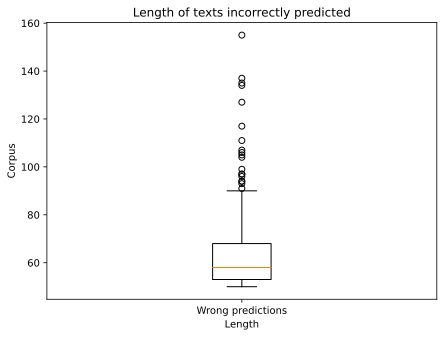

In [6]:
# boxplot the length of the texts in totally wrong and original df with matplotlib
fig, ax = plt.subplots(figsize=(7, 5))
ax.boxplot(totally_wrong['n_words'], labels=['Wrong predictions'])
ax.set_title('Length of texts incorrectly predicted')
ax.set_xlabel('Length') 
ax.set_ylabel('Corpus')
plt.show();